# COVID-19 NL Dashboard and Models

All data is sourced from [CoronaWatchNL](https://github.com/J535D165/CoronaWatchNL), which contains open data on COVID-19 provided by the local authorities.


In [18]:
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.data import *
from sklearn.linear_model import LinearRegression

%matplotlib inline

## 1. Predict COVID-19 cases from virus-particles in sewage.

In [3]:
cases = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-geo/data-national/RIVM_NL_national.csv", parse_dates=["Datum"])
sewage = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-dashboard/data-sewage/RIVM_NL_sewage_counts.csv", parse_dates=["Datum"])

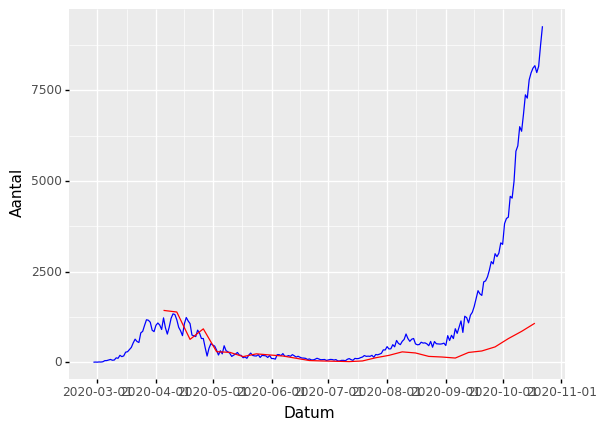

<ggplot: (159644036509)>

In [4]:
(
    ggplot(aes(x = "Datum", y = "Aantal"))
    + geom_line(data = cases[cases["Type"] == "Totaal"], color = 'blue')
    + geom_line(data = sewage, color = 'red')
)

In [5]:
sewage.head()

,Datum,Type,Aantal
0,2020-04-05,Virusdeeltjes per ml rioolwater,1430.85
1,2020-04-12,Virusdeeltjes per ml rioolwater,1386.00
2,2020-04-19,Virusdeeltjes per ml rioolwater,631.11
3,2020-04-26,Virusdeeltjes per ml rioolwater,921.63
4,2020-05-03,Virusdeeltjes per ml rioolwater,291.90


In [14]:
cases_sewage = pd.DataFrame()
cases_sewage["Cases"] = cases[cases['Datum'].isin(sewage['Datum'])][cases['Type'] == 'Totaal']['Aantal'].values
cases_sewage["Particles"] = sewage['Aantal']
cases_sewage.set_index(sewage["Datum"], inplace=True)
cases_sewage.head()

,Cases,Particles
Datum,,
2020-04-05,1224.0,1430.85
2020-04-12,1174.0,1386.00
2020-04-19,1066.0,631.11
2020-04-26,655.0,921.63
2020-05-03,335.0,291.90


In [42]:
X = cases_sewage["Particles"].values.reshape(-1, 1)
y = cases_sewage["Cases"].values.reshape(-1, 1)

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.30807319036133796

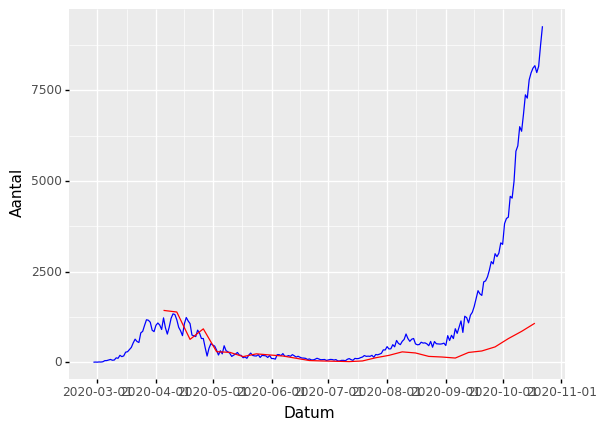

<ggplot: (159648448010)>

In [56]:
(
    ggplot(aes(x = "Datum", y = "Aantal"))
    + geom_line(data = cases[cases["Type"] == "Totaal"], color = 'blue')
    + geom_line(data = sewage, color = 'red')
    #+ geom_point(data = tests[tests["Type"] == "Totaal"])
)

In [45]:
tests.head()

,Jaar,Week,BeginDatum,EindDatum,AantalLaboratoria,Type,Aantal
0,2020,11,2020-03-09,2020-03-15,30,Totaal,17080
1,2020,11,2020-03-09,2020-03-15,30,Positief,1529
2,2020,12,2020-03-16,2020-03-22,35,Totaal,21338
3,2020,12,2020-03-16,2020-03-22,35,Positief,3953
4,2020,13,2020-03-23,2020-03-29,37,Totaal,24745


In [53]:
tests.tail()

,Datum,Type,Aantal
59,2020-10-04,Positief,18482
60,2020-10-13,Totaal,228707
61,2020-10-13,Positief,27459
62,2020-10-18,Totaal,195840
63,2020-10-18,Positief,24584


In [138]:
from autoimpute.imputations import SingleImputer

In [125]:
cases_sewage2 = pd.merge(cases[cases["Type"] == "Totaal"], sewage[["Datum", "Aantal"]], on = "Datum", how = "left", suffixes=("_Personen", "_Virusdeeltjes"))
cases_sewage2.drop(columns="Type", inplace=True)
cases_sewage2 = cases_sewage2.iloc[38:]


In [167]:
sewage_imputed = SingleImputer(strategy="least squares").fit_transform(cases_sewage2.iloc[1:,1:])

In [168]:
sewage_imputed

,Aantal_Personen,AantalCumulatief,Aantal_Virusdeeltjes
39,952.0,18803.0,1079.767231
40,777.0,19580.0,982.052540
41,969.0,20549.0,1058.377693
42,1213.0,21762.0,1155.686836
43,1335.0,23097.0,1191.990238
...,...,...,...
234,8182.0,228234.0,1077.410000
235,7992.0,236226.0,794.497284
236,8165.0,244391.0,739.640910
237,8743.0,253134.0,870.637568


In [169]:
sewage_imputed["Datum"] = cases_sewage2.iloc[1:,0]

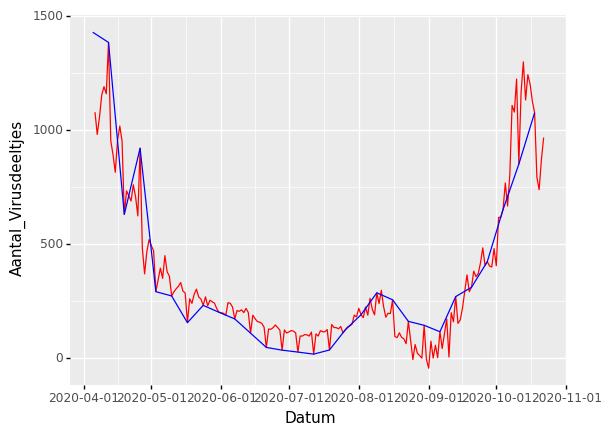

<ggplot: (159656206333)>

In [170]:
(
    ggplot(aes(x = "Datum", y = "Aantal_Virusdeeltjes"))
    + geom_line(data = sewage_imputed, color = "red")
    + geom_line(aes(y = "Aantal"), data = sewage, color = "blue")
)

In [171]:
X = sewage_imputed["Aantal_Virusdeeltjes"].values.reshape(-1, 1)
y = sewage_imputed["Aantal_Personen"].values.reshape(-1, 1)

reg2 = LinearRegression().fit(X, y)

reg2.score(X, y)

0.4664927404656234

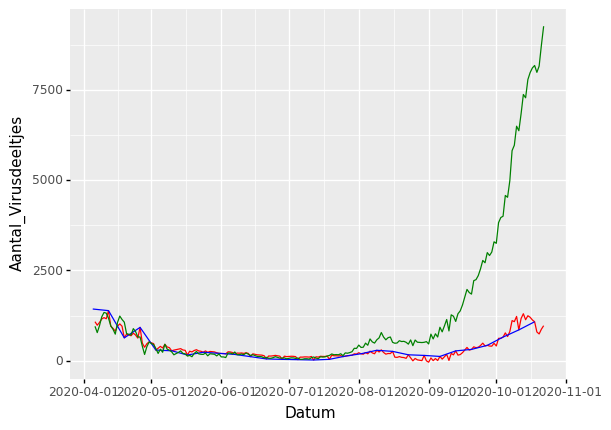

<ggplot: (159656181393)>

In [161]:
(
    ggplot(aes(x = "Datum", y = "Aantal_Virusdeeltjes"))
    + geom_line(data = sewage_imputed, color = "red")
    + geom_line(aes(y = "Aantal"), data = sewage, color = "blue")
    + geom_line(aes(y = "Aantal_Personen"), data = sewage_imputed, color = "green")
)

### To do list:
1. Idee: Corrigeren voor onvoldoende testcapaciteit tijdens de eerste golf (inschatten daadwerkelijk aantal besmetten personen).
2. Check voor MiceImputer https://pypi.org/project/autoimpute/0.12.1/

In [172]:
tests = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-misc/data-test/RIVM_NL_test_latest.csv", parse_dates=["BeginDatum", "EindDatum"])
tests["Datum"] = tests["EindDatum"]
tests = tests[["Datum", "Type", "Aantal"]]

In [177]:
tests = tests.pivot(index="Datum", columns="Type", values="Aantal")
tests["Percentage"] = tests["Positief"] / tests["Totaal"] * 100
tests

Type,Positief,Totaal,Percentage
Datum,,,
2020-03-15,1529,17080,8.951991
2020-03-22,3953,21338,18.525635
2020-03-29,7232,24745,29.226106
2020-04-05,7424,29098,25.513781
2020-04-12,8391,38960,21.537474
2020-04-19,7140,40102,17.804598
2020-04-26,4947,38395,12.884490
2020-05-03,2906,28954,10.036610
2020-05-10,2072,29006,7.143350
